This notebook uses Azure Cognitive Services to transcribe text on an old map.
It then puts the text with its geographic location into a shapefile.
A blog post about it is here: http://jeffblackadar.ca/

In [12]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic
#%%pycodestyle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 350 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 432 kB/s 
     |████████████████████████████████| 66 kB 4.5 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.13.0
    Uninstalling importlib-metadata-4.13.0:
      Successfully uninstalled importlib-metadata-4.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.2.0 which is in

In [1]:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install geopandas
!pip install contextily
!pip install -U rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade azure-cognitiveservices-vision-computervision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/python-sdk
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [5]:
import os
from IPython.display import clear_output
print('Enter your secret computer vision key:')
cv_subscription_key = input()

# Change the cv_endpoint below to your endpoint
cv_endpoint = "https://image-object-detection.cognitiveservices.azure.com/"

# Store as enivonmental variables
os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY'] = cv_subscription_key
os.environ['COMPUTER_VISION_ENDPOINT'] = cv_endpoint

# Do some basic validation
if len(os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']) == 32:
    print("Success, COMPUTER_VISION_SUBSCRIPTION_KEY is loaded.")
else:
    print("Error,",
          "The COMPUTER_VISION_SUBSCRIPTION_KEY is not the expected length,",
          "please check it.")
print("Done.")
print("Delete this output")
clear_output(wait=False)

In [6]:
computervision_client = ComputerVisionClient(cv_endpoint, CognitiveServicesCredentials(cv_subscription_key))

# Set this up for a series of images

In [7]:
import math


def recognize_text_in_local_image(local_image_handwritten_path):
    local_image_handwritten = open(local_image_handwritten_path, "rb")
    # Call API with image and raw response (allows you to get the operation location)
    recognize_handwriting_results = computervision_client.read_in_stream(local_image_handwritten, raw=True, language='en')

    # Get the operation location (URL with an ID at the end) from the response
    operation_location_remote = recognize_handwriting_results.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = operation_location_remote.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results
    while True:
        get_handw_text_results = computervision_client.get_read_result(operation_id)
        if get_handw_text_results.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    # Print the detected text, line by line
    lines_of_text = []
    if get_handw_text_results.status == OperationStatusCodes.succeeded:
        for text_result in get_handw_text_results.analyze_result.read_results:
            for line in text_result.lines:
                line_data = []
                # print(line.text)
                line_data.append(line.text)
                # print(line.bounding_box)
                line_data.append(line.bounding_box)
                pts = line_data[1]
                xd = abs(pts[4] - pts[0])
                yd = abs(pts[5] - pts[1])
                word_length = math.sqrt((xd ** 2) + (yd ** 2))
                letter_length = round(word_length/len(line.text))
                print(line.text, str(letter_length))
                line_data.append(letter_length)
                lines_of_text.append(line_data)
    return (lines_of_text)

In [13]:
import cv2
import matplotlib.pyplot as plt
import gdal
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon

font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10, 500)
fontScale = 1
fontColor = (0, 0, 200)
fontColor_small = (200, 0, 0)
lineType = 2


def get_point_from_pixel(x, y, xoffset, px_w, rot1, yoffset, px_h, rot2):
    # supposing x and y are your pixel coordinate this
    # is how to get the coordinate in space.
    posX = px_w * x + rot1 * y + xoffset
    posY = rot2 * x + px_h * y + yoffset
    posX = (px_w * x) + (rot1 * y) + xoffset
    posY = (px_h * y) + (rot2 * x) + yoffset
    # shift to the center of the pixel
    posX += px_w / 2.0
    posY += px_h / 2.0
    return (posX, posY)


def geocode_labels(local_image_handwritten_path, lines_of_text, geotif_crs):
    img = cv2.imread(local_image_handwritten_path)
    img_ds = gdal.Open(local_image_handwritten_path)
    xoffset, px_w, rot1, yoffset, rot2, px_h = img_ds.GetGeoTransform()

    line_text_poly = gpd.GeoDataFrame()
    line_text_poly['geometry'] = None
    line_text_poly.crs = ("EPSG:" + str(geotif_crs))
    line_text_poly.geometry = line_text_poly.geometry.to_crs(crs=geotif_crs)
    line_text_poly.to_crs(crs=geotif_crs)
    line_text_poly = line_text_poly.to_crs(epsg=geotif_crs)

    ln = 0
    for line in lines_of_text:
        pts = line[1]
        letter_size = line[2]
        fColor = fontColor
        if (letter_size < 90):
            p = []
            for cn in range(0, 4):
                p.append(get_point_from_pixel(pts[0+(cn*2)],
                                              pts[1+(cn*2)],
                                              xoffset,
                                              px_w,
                                              rot1,
                                              yoffset,
                                              px_h,
                                              rot2))
            coords = [(p[0][0], p[0][1]),
                      (p[1][0], p[1][1]),
                      (p[2][0], p[2][1]),
                      (p[3][0], p[3][1])]

            poly = Polygon(coords)
            new_tp_row = {'id':ln, 'geometry':poly,'text':line[0]}
            line_text_poly = line_text_poly.append(new_tp_row,
                                                   ignore_index=True)
    
    return(line_text_poly)

In [9]:
import os

def check_path(fp):
    if not os.path.exists(fp):
        print("missing: ", fp)
        os.makedirs(fp)
        if not os.path.exists(fp):
            print("still missing: ", fp)
        else:
            print("made directory: ", fp)
    else:
        print("exists:", fp)

In [10]:
tiletiff_folder = os.path.join("/content/drive/MyDrive/","tiletiff/")
tiletiff_maps_folder = os.path.join(tiletiff_folder,"maps/")
tiletiff_source_map_folder = os.path.join(tiletiff_maps_folder,"ta-map-150-iii-so/")
tiletiff_tiles_folder = os.path.join(tiletiff_source_map_folder,"tif_tiles/")
transcription_folder = os.path.join(tiletiff_source_map_folder,"transcription/")
check_path(transcription_folder)


tiles = []
import os
for filename in os.listdir(tiletiff_tiles_folder):
    if filename.endswith(".tif"):
        print("        tiles.append('" +
              os.path.join(tiletiff_tiles_folder, filename) +
              "')")
        tiles.append(os.path.join(tiletiff_tiles_folder, filename))

exists: /content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/transcription/
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c00.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c01.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c04.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c03.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c05.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c02.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c06.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r01c00.tif')
        tiles.append('/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r01c02.tif')
        tiles.append('

In [14]:
import rasterio
map_file_name = "ta-map-150-iii-so-4806.tif"
map_file_path = os.path.join(tiletiff_source_map_folder, map_file_name)

all_line_text_poly = gpd.GeoDataFrame()
all_line_text_poly['geometry'] = None

map_raterio_dataset = rasterio.open(map_file_path)
map_crs = map_raterio_dataset.crs
if (map_crs.is_valid):
    map_crs_int = int(str(map_crs)[5:])
    print("The map has a crs of:", map_crs_int)
else:
    print("There is likely a problem with the crs of the map",
          "or the map file itself.",
          "Check if the map is a geotiff, load it in QGIS.")
    sys.exit()

all_line_text_poly.crs = ("EPSG:" + str(map_crs_int))
all_line_text_poly.geometry = all_line_text_poly.geometry.to_crs(crs=map_crs_int)
all_line_text_poly.to_crs(crs=map_crs_int)
all_line_text_poly = all_line_text_poly.to_crs(epsg=map_crs_int)

for tile in tiles:
    print(tile)
    lines_of_text = recognize_text_in_local_image(tile)
    temp_df = geocode_labels(tile, lines_of_text, map_crs_int)
    all_line_text_poly = gpd.GeoDataFrame(pd.concat([all_line_text_poly, temp_df], ignore_index=True), crs=all_line_text_poly.crs)

all_line_text_poly.to_file(os.path.join(transcription_folder,
                                        "all_line_text.shp"))

The map has a crs of: 4806
/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c00.tif
F 88
8 heals of 21
cable ricardo 25
Fontk 30
Porile 19
/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c01.tif
Wall frot 27
150 della Carta d' Itali 41
Nelly Sch I.79 39
a road Decid La Torretta ou Dec 25
zuo 31
Ca 42
Piz 24
Oto 26
Cisterhole 29
fungo 30
45 B 20
Qte Mas 27
acchia 29
/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c04.tif
NO 124
NE of C. Donna 25
Minipia ugrotta d'acque 24
por Fontanile gy ancière 22
Tower ! 1660 27
Medaglia 36
112 17
Fontanile 23
77-5 11
/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c03.tif
TEL 116
ROMA 115
At astrous 32
te migliore 16
out which IS 550 13
idine dal meridiar 24
di Roma ( Monte M 30
(Cecchignola 33
Torraccib 14
. 96 12
K,16 18
-1 11 10
dello Schizzanell 26
/content/drive/MyDrive/tiletiff/maps/ta-map-150-iii-so/tif_tiles/r00c05.tif
Aero Solforatabla 24
inderi 21
Puderk 24
dell

epsg:4806
epsg:4806


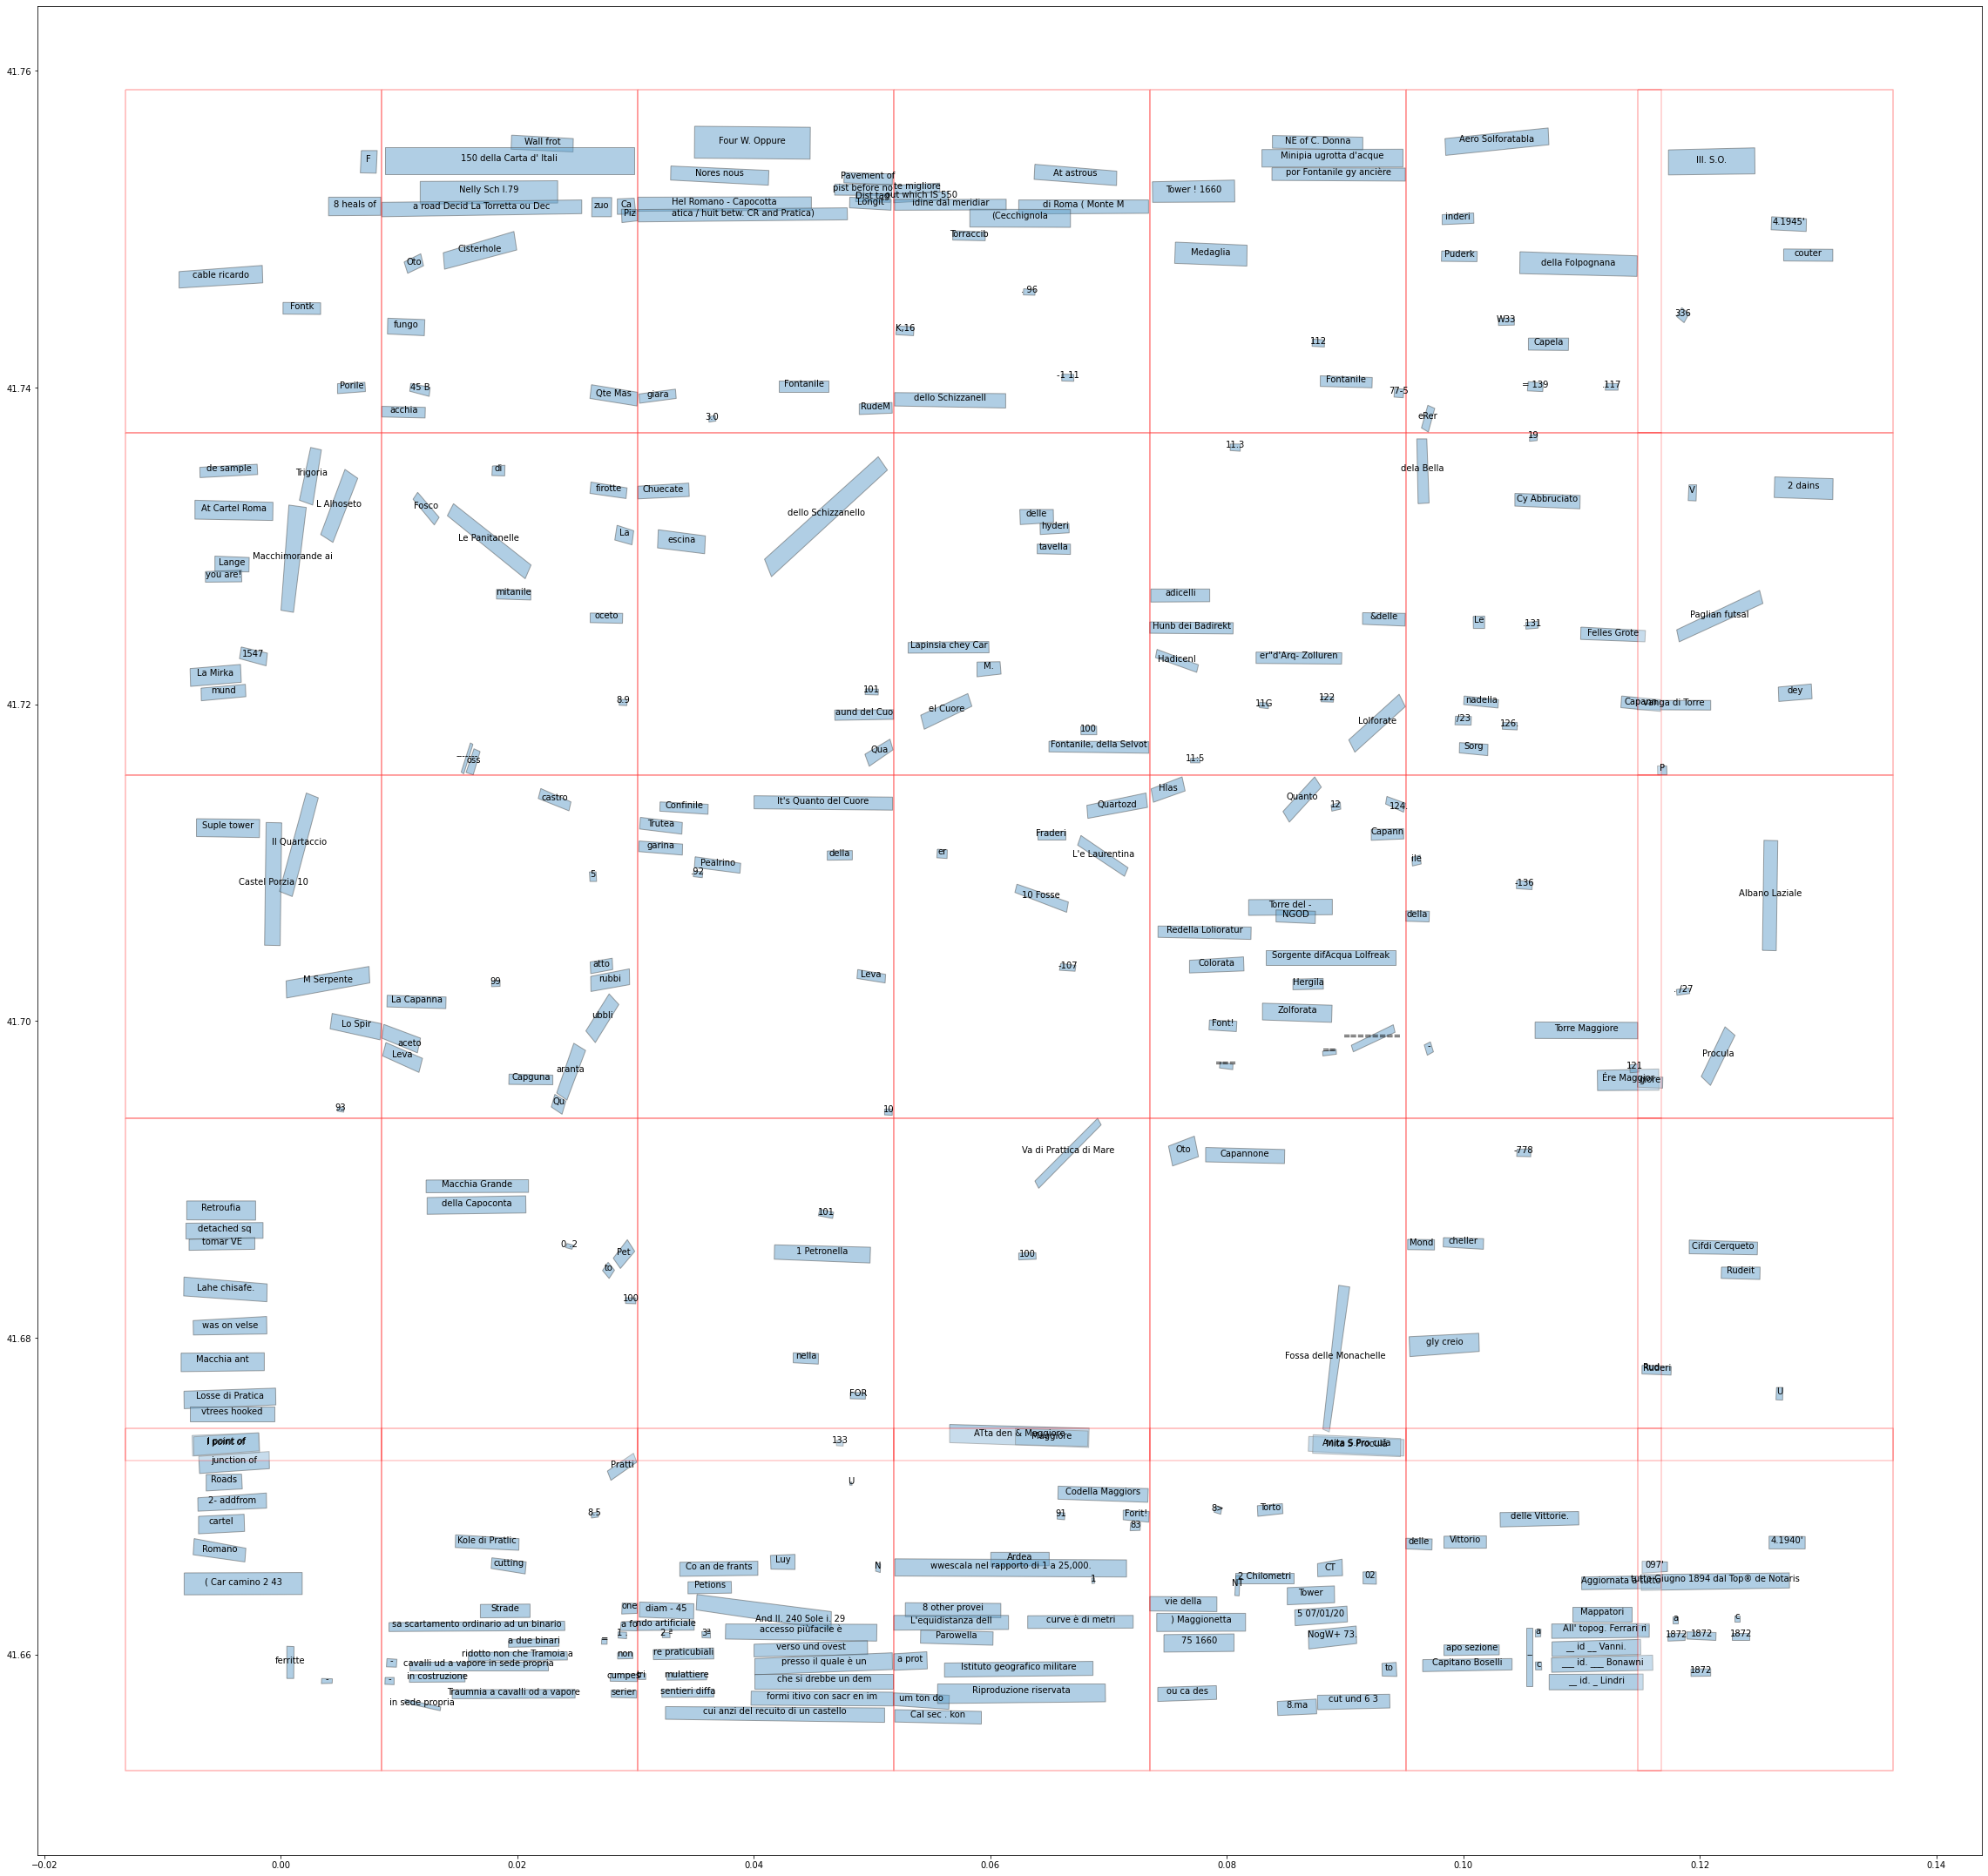

In [39]:
line_text_df=gpd.read_file(os.path.join(transcription_folder,"all_line_text.shp"))
import contextily as cx
print(line_text_df.crs)
# Change crs to one compatible with basemap
line_text_df = line_text_df.to_crs(epsg=4806) #3857 #32129 (fix this)
print(line_text_df.crs)

ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')

tile_polys_df=gpd.read_file(os.path.join(tiletiff_tiles_folder,"tile_polys.shp"))

#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3, facecolor="white")

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'], horizontalalignment='center')

In [ ]:
glist = line_text_df['geometry']
tlist = line_text_df['text']
rows_to_remove = []
print(len(glist))
for i in range(len(glist)):
    for j in range(i + 1, len(glist)):
        intersect_poly = glist[i].intersection(glist[j])

        if(not intersect_poly.is_empty):
            if(glist[i].area < glist[j].area):
                # glist[i] is smaller
                if(intersect_poly.area/glist[i].area >.8):
                    print("remove i : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), int(intersect_poly.area), " Remove: ", tlist[i], int(glist[i].area), " Keep: ", tlist[j], int(glist[j].area))
                    rows_to_remove.append(i)
            else:
                if(glist[i].area >= glist[j].area):  
                  if(intersect_poly.area/glist[j].area >.8):
                        print("remove j : ", i, j, "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), " Keep: ", tlist[i], int(glist[i].area),  " Remove: ", tlist[j], int(glist[j].area))
                        rows_to_remove.append(j)
                    #else:             
                    #    print("keep both: ", i, j, "{:3.2%}".format(intersect_poly.area/glist[i].area), "{:3.2%}".format(intersect_poly.area/glist[j].area), int(intersect_poly.area), tlist[i], int(glist[i].area), tlist[j], int(glist[j].area))


448
remove i :  0 6 100.00% 0  Remove:  F 0  Keep:  F. 150 della Carta d' 0
remove i :  1 8 89.79% 0  Remove:  8 heals of 0  Keep:  heales of a road Decuid La Torretta ou Deci 0
remove j :  4 13 97.83% 0  Keep:  Porile 0  Remove:  Contle 0
remove j :  4 77 95.28% 0  Keep:  Porile 0  Remove:  Te 0
remove j :  4 89 100.00% 0  Keep:  Porile 0  Remove:  onile 0
remove j :  6 16 100.00% 0  Keep:  F. 150 della Carta d' 0  Remove:  ta 0
remove j :  7 20 95.67% 0  Keep:  Nelly Sch 1. 79 0  Remove:  79 0
remove j :  8 21 98.69% 0  Keep:  heales of a road Decuid La Torretta ou Deci 0  Remove:  à di Deci 0
remove j :  13 77 93.19% 0  Keep:  Contle 0  Remove:  Te 0
remove j :  13 89 100.00% 0  Keep:  Contle 0  Remove:  onile 0
remove j :  15 90 96.44% 0  Keep:  fella Macchia 0  Remove:  Macchia 0
remove j :  25 98 89.68% 0  Keep:  Que Maggiara 0  Remove:  te Maggiara 0
remove i :  32 43 97.89% 0  Remove:  Torraccio 0  Keep:  Torraccio 0
remove i :  34 105 89.02% 0  Remove:  Fontanile 0  Keep:  Fon

In [ ]:
print(rows_to_remove)
# remove the rows
line_text_df_deduplicated = line_text_df
line_text_df_deduplicated = line_text_df_deduplicated.drop(rows_to_remove)
print(len(line_text_df_deduplicated['geometry']))
print(line_text_df_deduplicated['coords'],type(line_text_df_deduplicated['coords']))
print(line_text_df_deduplicated)
print(line_text_df_deduplicated.columns)

print(type(line_text_df_deduplicated))
#we have to drop this since .shp files don't support tuples
line_text_df_deduplicated = line_text_df_deduplicated.drop(columns='coords')
line_text_df_deduplicated.to_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))

print(line_text_df_deduplicated.columns)

[0, 1, 13, 77, 89, 16, 20, 21, 77, 89, 90, 98, 32, 34, 48, 106, 107, 38, 47, 48, 48, 57, 58, 66, 55, 134, 122, 66, 134, 75, 70, 74, 77, 96, 86, 87, 128, 119, 176, 190, 120, 134, 127, 130, 176, 190, 149, 148, 212, 157, 214, 220, 214, 220, 163, 163, 167, 178, 190, 187, 187, 248, 195, 196, 251, 253, 216, 220, 217, 222, 269, 275, 228, 224, 276, 277, 227, 240, 241, 289, 242, 296, 247, 262, 314, 315, 269, 274, 325, 326, 327, 288, 345, 385, 317, 312, 323, 318, 324, 323, 351, 355, 357, 364, 371, 360, 363, 367, 388, 380, 399, 402, 416, 417, 420, 422, 426, 428, 430, 447]
346
2      (-0.005058023447405678, 41.746969549905735)
3      (0.0017892839172641162, 41.744999715504406)
4       (0.005979491283378692, 41.739999366639495)
5         (0.02211114152907156, 41.75539005080812)
6        (0.01581075181412786, 41.754286077682096)
                          ...                     
442        (0.1124030618380199, 41.65944179823792)
443      (0.12017957841689103, 41.659820612545865)
444       (0.1122623

In [ ]:
import rasterio
import rasterio.plot
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=32127) #3857

print(line_text_df.crs)

ax = line_text_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

for tf in tiles:
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)
#ctx.add_basemap(ax)

tile_polys_df=gpd.read_file(os.path.join(map_base_dir,"tif_tiles/tile_polys.shp"))
#tile_polys_df = tile_polys_df.to_crs(epsg=3857) #3857
#tile_polys_df = tile_polys_df.to_crs(epsg=32637) #3857
tile_polys_df.boundary.plot(ax=ax,color="red",alpha=0.3)

line_text_df['coords'] = line_text_df['geometry'].apply(lambda x: x.representative_point().coords[:])
line_text_df['coords'] = [coords[0] for coords in line_text_df['coords']]
for idx, row in line_text_df.iterrows():
    plt.annotate(s=row['text'], xy=row['coords'],                 horizontalalignment='center')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
line_text_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_df.crs)
# Change crs to one compatible with basemap
#line_text_df = line_text_df.to_crs(epsg=3857) #3857
#line_text_df = line_text_df.to_crs(epsg=4326) #3857
ax = line_text_df.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
for tf in tiles:
    tif_file = rasterio.open(tf)
    rasterio.plot.show(tif_file, ax=ax)

line_text_df.boundary.plot(ax=ax,color="red",alpha=0.5)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Remove all of the labels that have only numbers
import rasterio
import rasterio.plot

line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_deduplicated.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
rows_dedup_to_remove = []
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(" i : ", i, tlist_dedup[i])
    if(tlist_dedup[i].isnumeric()):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])
    if(len(tlist_dedup[i])==1):
        rows_dedup_to_remove.append(i)
        print("remove i : ", i, tlist_dedup[i])

print(rows_dedup_to_remove)
# remove the rows
line_text_df_no_nums = line_text_dedup_df
line_text_df_no_nums = line_text_dedup_df.drop(rows_dedup_to_remove)
print(len(line_text_df_no_nums['geometry']))

#print(line_text_df_no_nums['coords'],type(line_text_df_no_nums['coords']))
print(line_text_df_no_nums)
print(line_text_df_no_nums.columns)

print(type(line_text_df_no_nums))

line_text_df_no_nums.to_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))

print(line_text_df_deduplicated.columns)


line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
line_text_dedup_df=gpd.read_file(os.path.join(map_base_dir,"all_line_text_no_nums.shp"))
print(line_text_dedup_df.crs)

glist_dedup = line_text_dedup_df['geometry']
tlist_dedup = line_text_dedup_df['text']
print(len(glist_dedup))
for i in range(len(glist_dedup)):
    print(i, tlist_dedup[i])

In [ ]:
import geopandas
line_text_df_search_file = os.path.join(map_base_dir,"all_line_text_search.shp")
shp_file = geopandas.read_file(line_text_df_search_file)
shp_file.to_file(os.path.join(map_base_dir,"all_line_text_search.geojson"), driver='GeoJSON')

Download /content/line_text.shp to use it in other maps such as ArcGIS Map. 